# Car Plates OCR
## Training notebook

## 1. Preparations

### Imports

In [1]:
from copy import deepcopy
import json
import random
import time
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import torch
import tqdm
from torch.utils import data
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.nn import functional as fnn

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torch.utils.tensorboard import SummaryWriter

np.random.seed(2205)
torch.manual_seed(2205)

### Dowdnload data

In [ ]:
from google.colab import files
files.upload()

In [ ]:
%%time
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list --mine
!kaggle datasets download -d xairete/car-plates-ocr
!unzip *.zip
!rm *.zip

#### Mount disc

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import sys

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/cv2')
%cd "./drive/My Drive/Colab Notebooks/cv2"
!ls

/content/drive/My Drive/Colab Notebooks/cv2
 car_plate_ocr.ipynb	        crnn_7_epochs_new.pth
'Copy of car_plate_ocr.ipynb'   crnn_8_epochs_new.pth
 crnn_0_epochs_new.pth	        crnn_9_epochs_new.pth
 crnn_10_epochs_new.pth         crnn_best_epochs_new.pth
 crnn_11_epochs_new.pth         data
 crnn_12_epochs_new.pth         detection.py
 crnn_13_epochs_new.pth         fasterrcnn_resnet50_fpn_0_back_epoch
 crnn_14_epochs_new.pth         fasterrcnn_resnet50_fpn_1_epoch
 crnn_15_epochs_new.pth         fasterrcnn_resnet50_fpn_2_epoch
 crnn_16_epochs_new.pth         fasterrcnn_resnet50_fpn_best_epoch
 crnn_17_epochs_new.pth         kaggle.json
 crnn_18_epochs_new.pth         predicted_boxes.json
 crnn_19_epochs_new.pth         __pycache__
 crnn_1_epochs_new.pth	        recognition.py
 crnn_2_epochs_new.pth	        runs
 crnn_3_epochs_new.pth	        s_1.csv
 crnn_4_epochs_new.pth	        s2.csv
 crnn_5_epochs_new.pth	        s3.csv
 crnn_6_epochs_new.pth	        test_boxes.json


## 2. Detection model

In [6]:
from detection import *

### Get detection dataset

In [ ]:
device = torch.device('cuda')
model = create_model(device)

normalize_trasnsformation= transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = CarPlatesDatasetWithRectangularBoxes('/content/data', normalize_trasnsformation, 'train')
val_dataset = CarPlatesDatasetWithRectangularBoxes('/content/data', normalize_trasnsformation, 'val')
test_dataset = CarPlatesDatasetWithRectangularBoxes('/content/data', normalize_trasnsformation, 'test')

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=collate_fn1)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=collate_fn1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


### Launch TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

### Train detection model

In [ ]:
writer = SummaryWriter()
model = train_detection(model, 
      device,
      train_loader,
      val_loader,
      num_epochs = 3, 
      writer = writer,
      weight_decay=0.0005, 
      optimizer_step_size=3,
      gamma=0.1)

## 3. Recognition model

In [7]:
from recognition import *

In [121]:
alphabet = "0123456789ABEKMHOPCTYX"
device = torch.device('cuda')
crnn = CRNN(alphabet)
crnn.to(device)

num_epochs = 40
batch_size = 128
num_workers = 4

optimizer = torch.optim.Adam(
    crnn.parameters(),
    lr=3e-4,
    amsgrad=True,
    weight_decay=1e-4)


transformations = transforms.Compose([
    Resize(),])

train_plates_dataset = CarPlatesFragmentsDataset('/content/data', 
                                                 transformations, 
                                                 'train',
                                                 alphabet=alphabet)

val_plates_dataset = CarPlatesFragmentsDataset('/content/data',
                                               transformations, 
                                               'val',
                                               alphabet=alphabet)


train_dataloader = torch.utils.data.DataLoader(train_plates_dataset, 
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=num_workers, pin_memory=True, 
                                               drop_last=True, collate_fn=collate_fn)

val_dataloader = torch.utils.data.DataLoader(val_plates_dataset, 
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=num_workers, pin_memory=True, 
                                             drop_last=True, collate_fn=collate_fn)

### Launch TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
writer = SummaryWriter()

crnn = train_recognition(crnn, 
      device,
      train_dataloader,
      val_dataloader,
      optimizer,
      writer,
      num_epochs = 20)

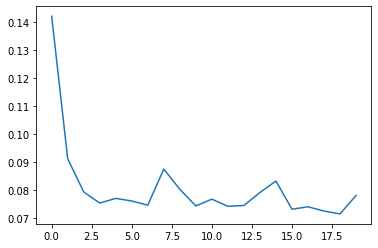

In [27]:
def plot_validation_loss(num_epochs, val_dataloader):
  val_loss = []
  for i in tqdm.tqdm(range(num_epochs)):
    with open(f'crnn_{i}_epochs_new.pth', 'rb') as fp:
      state_dict = torch.load(fp, map_location="cpu")
    crnn.load_state_dict(state_dict)
    val_loss.append(validate_recognition(crnn,device, val_dataloader))
  plt.plot(range(20), vall_loss)


get_best_model(20, val_dataloader)

# best model on iter 19 with validation loss 0.0716

## 4. Complete pipeline

### Load best detection and recognition models

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

alphabet = "0123456789ABEKMHOPCTYX"
device = torch.device('cuda')
crnn = CRNN(alphabet)
crnn.to(device)

with open(f'crnn_{18}_epochs_new.pth', 'rb') as fp:
  state_dict = torch.load(fp, map_location="cpu")
crnn.load_state_dict(state_dict)

model = create_model(device)
with open('fasterrcnn_resnet50_fpn_best_epoch', 'rb') as fp:
    state_dict = torch.load(fp, map_location="cpu")
model.load_state_dict(state_dict)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

### Get boxes

In [ ]:
normalize_trasnsformation= transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_dataset = CarPlatesDatasetWithRectangularBoxes('/content/data', normalize_trasnsformation, 'test')

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=collate_fn1)

predicted_boxes = []
for batch in test_loader:
    images = list(image.to(device) for image in batch[0])
    model.eval()
    preds = model(images)
    preds = [{k: v.detach().cpu().numpy() for k, v in prediction.items()} for prediction in preds]
    predicted_boxes.extend(preds)

boxes = []
for item in predicted_boxes:
  if len(item["boxes"]) == 0:
    boxes.append([])
  elif len(item["boxes"]) == 1:
    box = item['boxes']
    boxes.append(box.astype(int).tolist())
  else:
    box = item['boxes']
    idx = np.argsort(box[:,0])
    scores = item['scores'][idx]
    box = box[idx]
    high_scored_boxes = box[scores > 0.9885]
    if high_scored_boxes.shape[1] * high_scored_boxes.shape[0] == 0:
      box = box[np.argmax(scores)]
      boxes.append([box.astype(int).tolist()])
    else:
      boxes.append(high_scored_boxes.astype(int).tolist())

assert len(boxes) == len(test_dataset) 


json_data = []
for file_name, box in zip(test_dataset.image_names, boxes):
    json_data.append({'boxes': box, 'file': str(file_name)})

with open('/content/data/test_boxes.json', 'w') as fp:
    json.dump(json_data, fp)

### Recognition text in boxes

In [116]:
transformations = transforms.Compose([
    Resize()]) # Resize is function from recognition.py 

test_plates_dataset = CarPlatesFragmentsDataset('/content/data', transformations, 'test')
test_dataloader = torch.utils.data.DataLoader(test_plates_dataset, 
                                              batch_size=1, shuffle=False,
                                              num_workers=num_workers, pin_memory=True, 
                                              drop_last=True, collate_fn=collate_fn)

crnn.eval()
submit = {}
for b in test_dataloader:
    file_name = str(b['file_name'][0]).split('data/')[1]
    if file_name not in submit:
            submit[file_name] = []
    images = b["image"]
    preds = crnn(images.to(device)).cpu().detach()
    texts_pred = decode(preds, alphabet)
    submit[file_name].append(texts_pred[0])

### Create Submission

In [119]:
submit = [(k, ' '.join(v)) for k,v in submit.items()]
submission = pd.DataFrame(submit, columns=['file_name', 'plates_string'])
random_submission = pd.read_csv('/content/data/submission.csv')
submission = pd.merge(random_submission, submission, how='left', on='file_name')
submission.drop('plates_string_x', axis=1, inplace=True)
submission.columns = ['file_name', 'plates_string']
submission

,file_name,plates_string
0,test/0.jpg,O195KC96
1,test/1.jpg,O001OO24 O005OO24
2,test/2.jpg,H030MB33
3,test/3.jpg,C139AP96
4,test/4.bmp,B955ET35
...,...,...
3183,test/3183.jpg,M143ME27
3184,test/3184.jpg,X411AX01
3185,test/3185.bmp,B692KT35
3186,test/3186.bmp,A184XE38


In [120]:
submission.to_csv('s3.csv', index=False)